#### To run this, install lxml.     how(windows): pip install lxml

In [1]:
!pip install lxml

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import os, csv
import requests
import pandas as pd
list=[]


# Quebec and Ontario only because North/West has one more column, will be done separately

# Going through 4th, 5th link on url
a=[4,5]

# list to store each dataframes
df_list = []

for x in a:
    url = f"https://internatlibs.mcgill.ca/hospitals/hospital-histories{x}.htm"
    data = requests.get(url).content

    # Scrapping all data from url    
    query = pd.read_html(data)
    
    # Getting 4th section which is the table into a dataframe. drop details
    df = pd.DataFrame(query[4]).drop(columns=[2])
    
    # rename column names and delete first row.
    df = df.rename(columns={0:"City", 1:"Hospital"})
    
    # delete first row and drop duplicate hospitals
    df = df.drop(df.index[0]).drop_duplicates(keep="first")
    
    # getting df with number of hospitals for each city, append it to list
    #  0th item is number of hospitals for each city of Quebec
    num_hos= df.groupby(["City"]).count().sort_values(by="Hospital", ascending=False)
    df_list.append(num_hos)

In [3]:
# Number of Hospitals for Quebec
num_hos_qb = df_list[0]
# get City back to column instead of index
num_hos_qb = num_hos_qb.reset_index()

# concat province 
num_hos_qb["City"] =num_hos_qb["City"] + ", Quebec"

display(num_hos_qb.head())


# number of hospitals for Ontario
num_hos_on = df_list[1]
num_hos_on = num_hos_on.reset_index()
num_hos_on["City"] = num_hos_on["City"] + ", Ontario"
display(num_hos_on.head())

,City,Hospital
0,"Montréal, Quebec",59
1,"Québec, Quebec",17
2,"Sherbrooke, Quebec",8
3,"Lévis, Quebec",3
4,"Rouyn-Noranda, Quebec",3


,City,Hospital
0,"Toronto, Ontario",42
1,"Hamilton, Ontario",14
2,"London, Ontario",10
3,"Ottawa, Ontario",10
4,"Thunder Bay, Ontario",7


### West and North

In [4]:
url = f"https://internatlibs.mcgill.ca/hospitals/hospital-histories6.htm"
data = requests.get(url).content
query = pd.read_html(data)

# Getting the table. this time it is 5th section, drop 1st row and details
df = pd.DataFrame(query[5]).drop(index=[0],columns=[3])

df = df.rename(columns={0:"Province", 1: "City", 2:"Hospital"})
# capitalize only first letter in 0 column
df["Province"] = df["Province"].str.title()


# merge City to Province. ex: Barrie, Ontario
df['Cities'] = df[['City','Province']].apply(lambda x: ', '.join(x.fillna('').map(str)), axis=1)
df = df.drop(columns=["Province", "City"])
df = df.rename(columns={"Cities":"City"})

# Change the order and drop duplicate hospitals
df = df[["City", "Hospital"]].drop_duplicates(keep="first")

# number of hospitals in each city.
num_hos_nw = df.groupby(["City"]).count().sort_values(by="Hospital", ascending=False)

display(num_hos_nw.head())

,Hospital
City,
"Winnipeg, Manitoba",17
"Edmonton, Alberta",13
"Calgary, Alberta",11
"Vancouver, British Columbia",10
"Victoria, British Columbia",7


In [5]:
# Merging Number of Hospitals for Quebec and number of hospitals for Ontario
merge_qb_on = pd.merge(num_hos_qb, num_hos_on,how='outer',on='City')
merge_qb_on["Hospital_x"] = merge_qb_on["Hospital_x"].fillna(0)
merge_qb_on["Hospital_y"] = merge_qb_on["Hospital_y"].fillna(0)
merge_qb_on.head()

,City,Hospital_x,Hospital_y
0,"Montréal, Quebec",59.0,0.0
1,"Québec, Quebec",17.0,0.0
2,"Sherbrooke, Quebec",8.0,0.0
3,"Lévis, Quebec",3.0,0.0
4,"Rouyn-Noranda, Quebec",3.0,0.0


In [6]:
# Merging Number of Hospitals for Quebec and Ontario and number of hospitals for North and West
merge_qb_on_nw = pd.merge(merge_qb_on, num_hos_nw,how='outer',on='City')
merge_qb_on_nw["Hospital_x"] = merge_qb_on_nw["Hospital_x"].fillna(0).astype(int)
merge_qb_on_nw["Hospital_y"] = merge_qb_on_nw["Hospital_y"].fillna(0).astype(int)
merge_qb_on_nw["Hospital"] = merge_qb_on_nw["Hospital"].fillna(0).astype(int)
merge_qb_on_nw.head()

,City,Hospital_x,Hospital_y,Hospital
0,"Montréal, Quebec",59,0,0
1,"Québec, Quebec",17,0,0
2,"Sherbrooke, Quebec",8,0,0
3,"Lévis, Quebec",3,0,0
4,"Rouyn-Noranda, Quebec",3,0,0


In [7]:
#Adding Total number of hospitals cities wise
merge_qb_on_nw["Hospitals"] = merge_qb_on_nw["Hospital_x"] + merge_qb_on_nw["Hospital_y"] + merge_qb_on_nw["Hospital"]


In [8]:
# deleting the unwanted hospitals columns and creating new summary dataframe of all the cities and number of hospitals
merged_summary= merge_qb_on_nw.drop(['Hospital_x', 'Hospital_y','Hospital'], axis=1)
# sort it alphabatically
merged_summary = merged_summary.sort_values(by=["City"]).reset_index(drop=True)
#displaying the merged file
merged_summary.head()

,City,Hospitals
0,"Alma, Quebec",1
1,"Almonte, Ontario",1
2,"Altona, Manitoba",1
3,"Amqui, Quebec",1
4,"Argyle, Manitoba",1


<IPython.core.display.Javascript object>


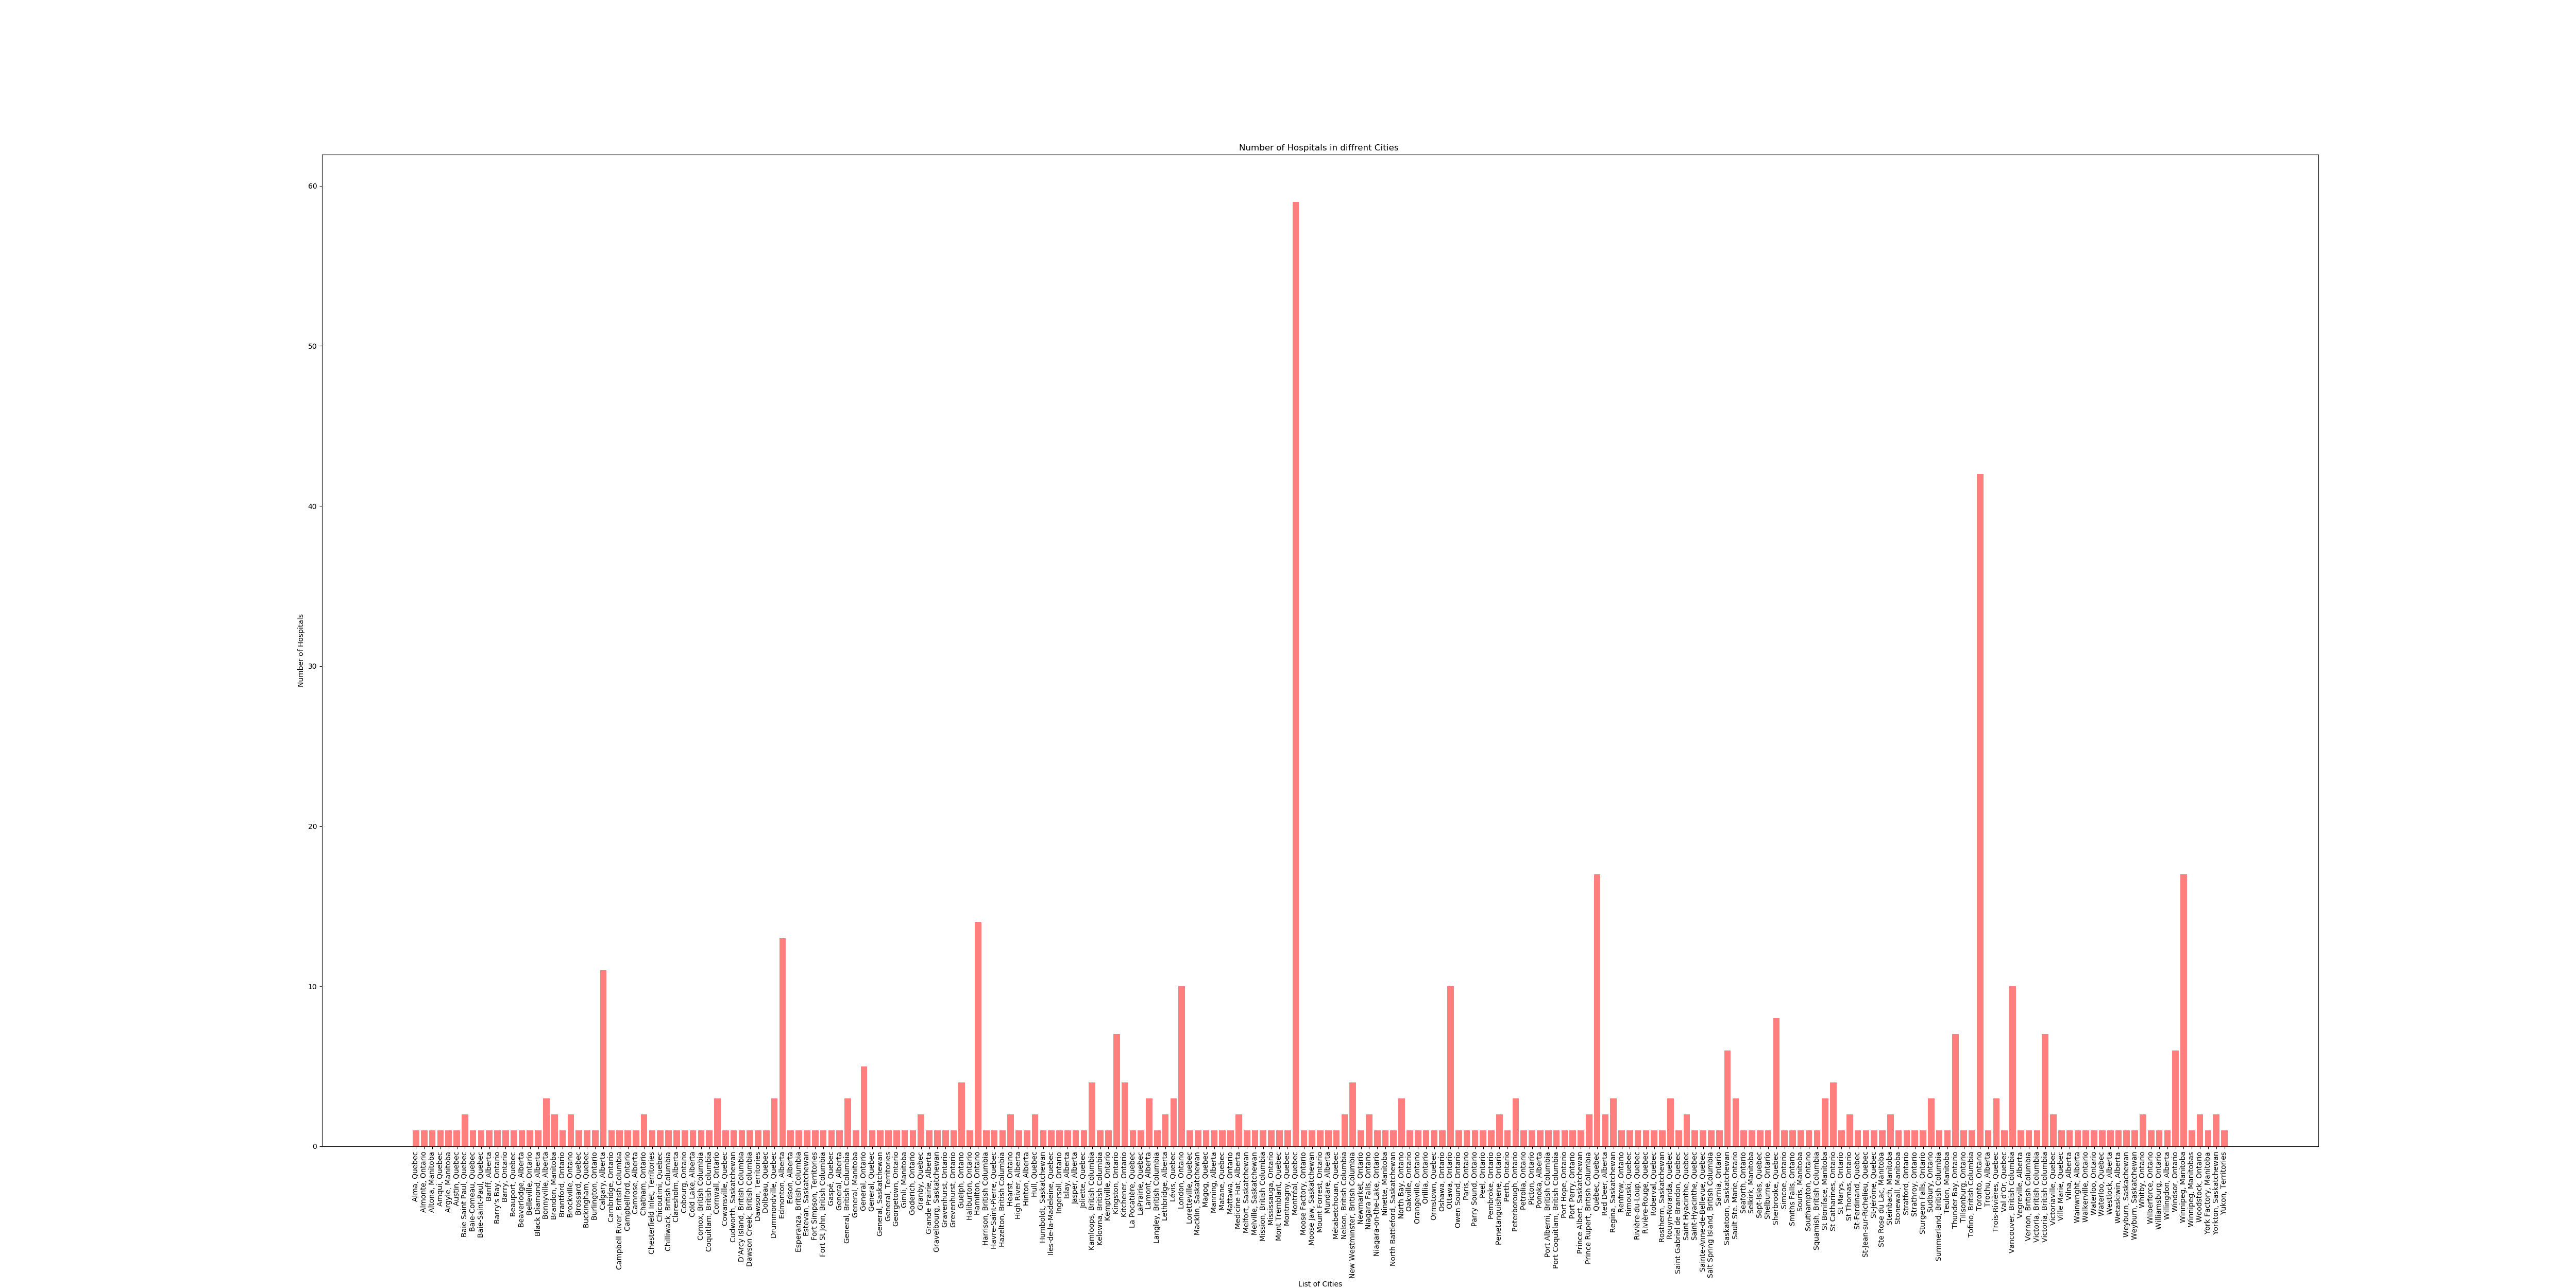

([<matplotlib.axis.XTick at 0x2cde33b6438>,
 <a list of 223 Text xticklabel objects>)

In [9]:
users = merged_summary["Hospitals"]

x_axis = np.arange(len(users))
tick_locations = [value+0.4 for value in x_axis]
# Tell matplotlib that we will be making a bar chart
# Users is our y axis and x_axis is, of course, our x axis
# We apply align="edge" to ensure our bars line up with our tick marks
plt.figure(figsize=(50,25))
plt.bar(x_axis, users, color='r', alpha=0.5, align="edge")
# Tell matplotlib where we would like to place each of our x axis headers
plt.xticks(tick_locations, merged_summary["City"], rotation="vertical")


In [10]:
# Give our chart some labels and a tile
plt.title("Number of Hospitals in diffrent Cities ")
plt.xlabel("List of Cities")
plt.ylabel("Number of Hospitals")

Text(0, 0.5, 'Number of Hospitals')